In [12]:
import sys, os
import numpy as np
sys.path.append('biceps/')
from toolbox import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Let's read the trajectory file ###
traj = 'traj_lambda1.00.npz'

rest_type = get_rest_type(traj)  # get restraint used in sampling
print "restraint_type", rest_type

restraint_type ['J', 'noe', 'gamma']


In [45]:
### Let's get the sampled parameters ###
allowed_parameters = get_allowed_parameters(traj,rest_type=rest_type)
sampled_parameters = get_sampled_parameters(traj,rest_type=rest_type,allowed_parameters=allowed_parameters)
print "sampled parameters of ",rest_type[0],"for first 100 steps", sampled_parameters[0][:100]

sampled parameters of  J for first 100 steps [0.9944797411048979, 0.9944797411048979, 0.9944797411048979, 0.9944797411048979, 0.9944797411048979, 0.9944797411048979, 0.9944797411048979, 0.9944797411048979, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0143693359269959, 1.0346567226455359, 1.0346567226455359, 1.0346567226455359, 1.0346567226455359, 1.0553498570984468, 1.0553498570984468, 1.0553498570984468, 1.0553498570984468, 1.0553498570984468, 1.0553498570984468, 1.0553498570984468, 1.0764568542404156, 1.0764568542404156, 1.0764568542404156, 1.0764568542404156, 1.0764568542404156, 1.0764568542404156, 1.0764568542404156, 1.076456854240

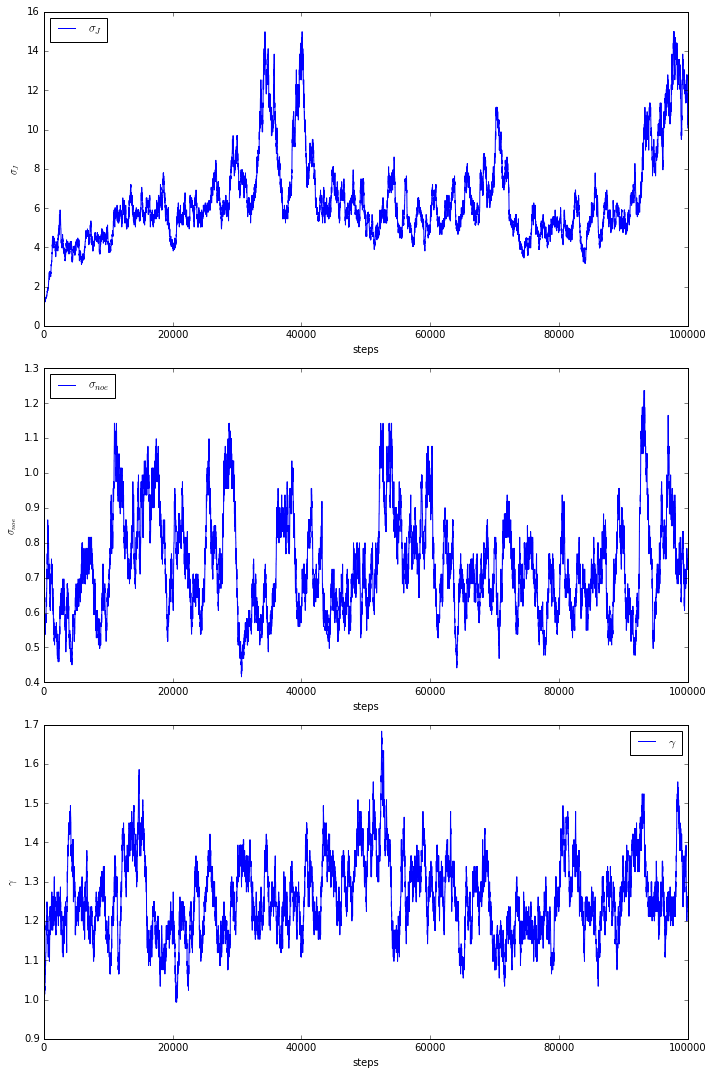

In [15]:
### Let's plot the traces of sampled parameters ###
total_steps = len(sampled_parameters[0])
x = np.arange(1,total_steps+0.1,1)
plt.figure(figsize=(10,15))
n_rest = len(rest_type)
for i in range(n_rest):
    if 'gamma' in rest_type:
        plt.subplot(n_rest,1,i+1)
        if i == n_rest-1:
            plt.plot(x,sampled_parameters[i],label='$\\%s$'%rest_type[i])
            plt.ylabel('$\%s$'%rest_type[i])
        else:
            plt.plot(x,sampled_parameters[i],label='$\\sigma_{%s}$'%rest_type[i])
            plt.ylabel('$\sigma_{%s}$'%rest_type[i])
        plt.xlabel('steps')
        plt.legend(loc='best')
    else:
        plt.subplot(n_rest,1,i+1)
        plt.plot(x,sampled_parameters[i],label='$\\sigma_{%s}$'%rest_type[i])
        plt.ylabel('$\sigma_{%s}$'%rest_type[i])
        plt.xlabel('steps')
        plt.legend(loc='best')
plt.tight_layout()


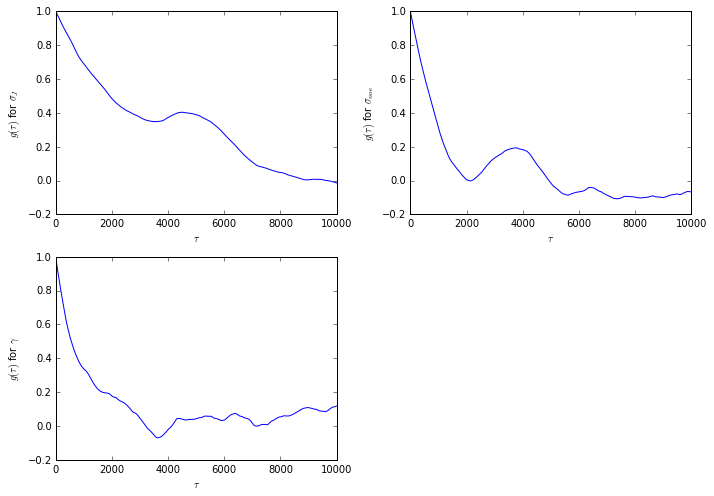

In [17]:
### Let's plot the autocorrelation curve ###
trace_labels = []
for i in rest_type:
    if i == 'gamma':
        trace_labels.append('$\\gamma$')
    else:
        trace_labels.append('$\\sigma_{%s}$'%i)
max_tau=10000
autocorrs = []
for timeseries in sampled_parameters:
    autocorrs.append( g(np.array(timeseries), max_tau=max_tau) )

plt.figure( figsize=(10,10))
for i in range(len(autocorrs)):
    plt.subplot(len(autocorrs),2,i+1)
    plt.plot(np.arange(max_tau+1),autocorrs[i])
    plt.ylabel('$g(\\tau)$ for %s'%trace_labels[i])
    plt.xlabel('$\\tau$')
plt.tight_layout()


best-fit tau1 =  6963.24111175 +/- 11217.3476165
best-fit tau1 =  977.541194307 +/- 71.6378799839
best-fit tau1 =  857.907778358 +/- 18.2419083533


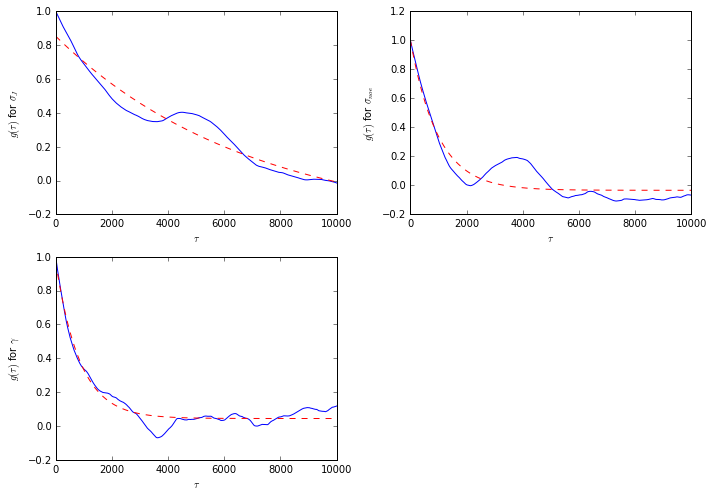

In [18]:
### Let's fit the curve line with exponential decay and plot them ###
plt.figure( figsize=(10,10))
for i in range(len(autocorrs)):
    yFit = exponential_fit(autocorrs[i])
    plt.subplot(len(autocorrs),2,i+1)
    plt.plot(np.arange(max_tau+1), autocorrs[i])
    plt.plot(np.arange(max_tau+1), yFit, 'r--')
    plt.xlabel('$\\tau$')
    plt.ylabel('$g(\\tau)$ for %s'%trace_labels[i])
plt.tight_layout()


Apparently $\sigma_J$ decorrelates more slowly than the other two parameters. For the sake of this example, let's just use step = 1000 as $\tau$.

In [23]:
### Let's subsample the raw trajectory and compute JSDs ###
tau = 2*1000
traj_sec = np.load('traj_lambda1.00.npz')['arr_0'].item()  # load "trajectory" section
T_new = traj_sec['trajectory'][::tau]    # subsample the raw trajectory based on tau
fold = 10      # divide new subsampled trajectory into 10 folds
nsnaps = len(T_new)      # count number of snapshots of new subsampled trajectory
dx = int(nsnaps/fold)
rounds = 10    # number of rounds for mixing data
all_JSD=[]      # create JSD list
all_JSDs=[[] for i in range(fold)]   # create JSD list of distribution
traj = 'traj_lambda1.00.npz'
for subset in range(fold):
    half = dx * (subset+1)/2
    T1 = T_new[:half]     # first half of the trajectory
    T2 = T_new[half:dx*(subset+1)]    # second half of the trajectory
    T_total = T_new[:dx*(subset+1)]     # total trajectory
    all_JSD.append(compute_JSD(T1,T2,T_total,rest_type,allowed_parameters))   # compute JSD 
    for r in range(rounds):      # now let's mix this dataset
        mT1 = np.random.choice(len(T_total),len(T_total)/2,replace=False)    # randomly pickup snapshots (index) as the first part
        mT2 = np.delete(np.arange(0,len(T_total),1),mT1)           # take the rest (index) as the second part
        temp_T1, temp_T2 = [],[]        
        for snapshot in mT1:
                temp_T1.append(T_total[snapshot])      # take the first part dataset from the trajectory
        for snapshot in mT2:
                temp_T2.append(T_total[snapshot])      # take the second part dataset from the trajectory
        all_JSDs[subset].append(compute_JSD(temp_T1,temp_T2,T_total,rest_type,allowed_parameters))    # compute JSD

print "Done"

# compute_JSD function will compute JSD for all restraints
# all_JSD.shape = (fold,n_rest)
# all_JSDs.shape = (fold,round,n_rest)

Done


biceps/toolbox.py:561: RuntimeWarning: divide by zero encountered in log
  H1 = -1.*r1/N1*np.log(r1/N1)
biceps/toolbox.py:561: RuntimeWarning: invalid value encountered in multiply
  H1 = -1.*r1/N1*np.log(r1/N1)
biceps/toolbox.py:563: RuntimeWarning: divide by zero encountered in log
  H2 = -1.*r2/N2*np.log(r2/N2)
biceps/toolbox.py:563: RuntimeWarning: invalid value encountered in multiply
  H2 = -1.*r2/N2*np.log(r2/N2)
biceps/toolbox.py:565: RuntimeWarning: divide by zero encountered in log
  H = -1.*r_total/N_total*np.log(r_total/N_total)
biceps/toolbox.py:565: RuntimeWarning: invalid value encountered in multiply
  H = -1.*r_total/N_total*np.log(r_total/N_total)


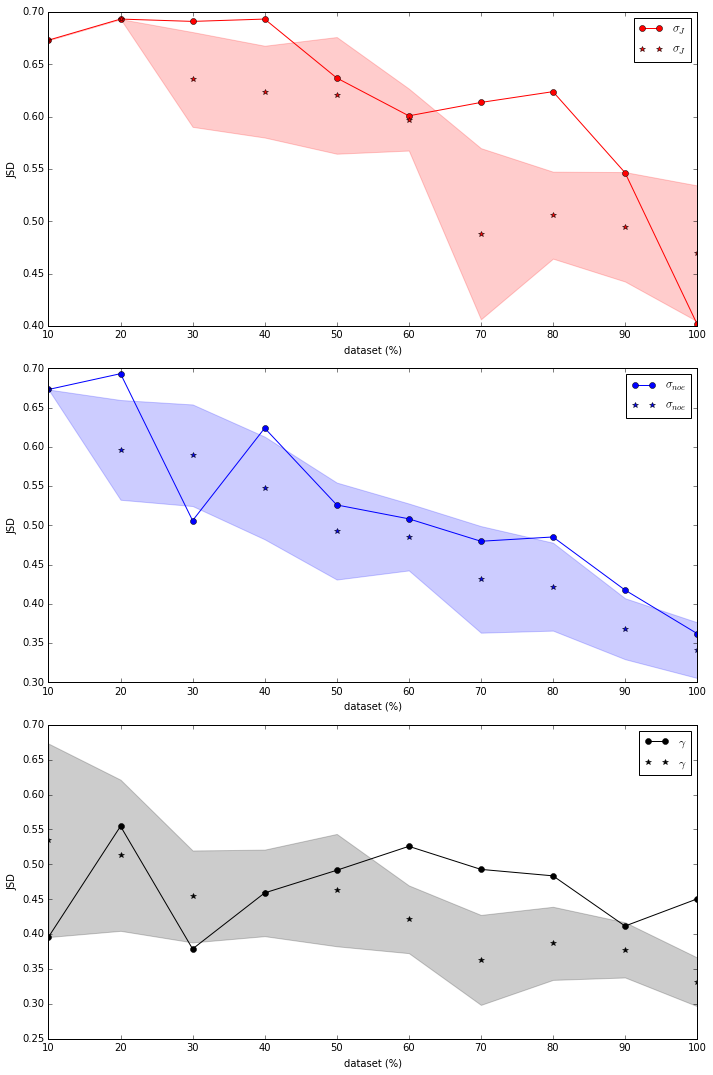

In [44]:
### Let's plot JSD distribution ###

colors=['red', 'blue','black','green']

# convert shape of all_JSD from (fold,n_rest) to (n_rest,fold)
new_JSD = [[] for i in range(n_rest)]   
for i in range(len(all_JSD)):
    for j in range(n_rest):
        new_JSD[j].append(all_JSD[i][j])  

# compute mean, std of JSDs from each fold dataset of each restraint
JSD_dist = [[] for i in range(n_rest)]
JSD_std = [[] for i in range(n_rest)]
for rest in range(n_rest):
    for f in range(fold):
        temp_JSD = []
        for r in range(rounds):
            temp_JSD.append(all_JSDs[f][r][rest])
        JSD_dist[rest].append(np.mean(temp_JSD))
        JSD_std[rest].append(np.std(temp_JSD))
#print JSD_dist     # JSD_dist.shape = (n_rest,fold)
#print JSD_std      # JSD_std.shape = (n_rest,fold)
plt.figure(figsize=(10,5*n_rest))
x=np.arange(10.,101.,10.)   # the dataset was divided into ten folds (this is the only hard coded part)
for i in range(n_rest):
    plt.subplot(n_rest,1,i+1)
    plt.plot(x,new_JSD[i],'o-',color=colors[i],label=trace_labels[i])
    plt.hold(True)
    plt.plot(x,JSD_dist[i],'*',color=colors[i],label=trace_labels[i])
    plt.fill_between(x,np.array(JSD_dist[i])+np.array(JSD_std[i]),np.array(JSD_dist[i])-np.array(JSD_std[i]),color=colors[i],alpha=0.2)
    plt.xlabel('dataset (%)')
    plt.ylabel('JSD')
    plt.legend(loc='best')
plt.tight_layout()